In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Subset

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torchvision.models import resnet101, resnet152, vit_b_16, efficientnet_b7
from torchvision import io
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from tqdm import tqdm
import csv
import numpy as np
import random 
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Initialize Dataset and Apply Augmentations

In [107]:
torch.manual_seed(26)
np.random.seed(26)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.TrivialAugmentWide(interpolation=transforms.InterpolationMode.BILINEAR), # AutoAugment uses a collection of augmentations from the paper, https://arxiv.org/pdf/1805.09501.pdf
        transforms.ToTensor(),
        transforms.RandomErasing(0.1)
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
    ]),
}

full_dataset = datasets.ImageFolder("./train/")
print(full_dataset)

train_idx, val_idx = train_test_split(list(range(len(full_dataset))), test_size=0.2)
my_datasets = {}
my_datasets['train'] = Subset(full_dataset, train_idx)
my_datasets['val'] = Subset(full_dataset, val_idx)

class MyDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

val_dataset = MyDataset(
    my_datasets['val'], transform=data_transforms['val']
)
train_dataset = MyDataset(
    my_datasets['train'], transform=data_transforms['train']
)

class_names = train_dataset.subset.dataset.classes

dataset_sizes = {'train': len(train_dataset),
                'val': len(val_dataset)}

# specify device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Using: {device}")

Dataset ImageFolder
    Number of datapoints: 1079
    Root location: ./train/
Using: cuda:0


# Get New Class Weights

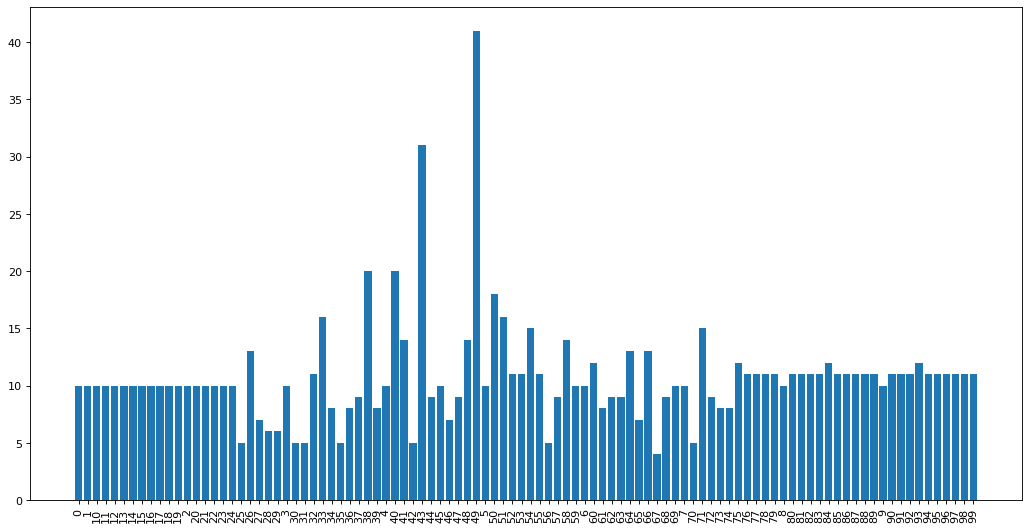

In [108]:
# Initialize a dictionary to store the count of samples for each class
class_sample_count = {class_name: 0 for class_name in class_names}

# Count the number of samples for each class
for _, label in full_dataset:
    class_sample_count[class_names[label]] += 1

figure(figsize=(16, 8), dpi=80)

plt.bar(range(len(class_sample_count)), list(class_sample_count.values()), align='center')
plt.xticks(range(len(class_sample_count)), list(class_sample_count.keys()),rotation=90)

plt.show()

class_weights = []
for c in class_names:
    class_weights.append(1 - (class_sample_count[c]/1079))
class_weights = torch.tensor(class_weights).to(device)

# Initialize Dataloaders

In [109]:
dataloaders = {'train': DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4),
               'val': DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4)}

# Train Model

In [110]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    train_loss = []
    val_loss = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                if phase=='train':
                    train_loss.append(epoch_loss)
                else:
                    val_loss.append(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, train_loss, val_loss, best_acc

## Run Experiment

In [119]:
num_trials = 1
best_model = None
best_overall_acc = 0
episode_data = []
episode_accuracies = []
epochs = 200
learning_rate = 0.01
num_labels = 100
weight_decay = 2e-05
momentum = 0.9
scheduler_t = epochs
label_smoothing = 0.1

for i in range(num_trials):
    # download pre-trained model
    my_model = efficientnet_b7(weights='IMAGENET1K_V1')
    # replace last fc layer to return 100 classes
    # num_ftrs = my_model.heads.head.in_features
    # my_model.heads.head = nn.Linear(num_ftrs, num_labels)
    num_ftrs = my_model.classifier[1].in_features
    my_model.classifier[1] = nn.Sequential(nn.Linear(num_ftrs, 100))
    my_model = my_model.to(device)
    
    # select Cross Entropy Loss as criterion
    # pass in our tailored class weights and add label smoothing
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)
    
    # Defined optimizer as SGD with Cosine Annealing LR scheduler
    optimizer = optim.SGD(my_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, scheduler_t)

    tuned_model, train_loss, val_loss, best_acc = train_model(my_model, criterion,  optimizer, scheduler, num_epochs=epochs)
    df = pd.DataFrame(train_loss, val_loss).reset_index()
    df = df.rename(columns={"index":"train loss", 0:"valid loss"})
    df['Trial'] = i
    episode_data.append(df)
    episode_accuracies.append(best_acc.item())
    if best_acc > best_overall_acc:
        best_overall_acc = best_acc
        best_model = tuned_model

Epoch 0/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.29it/s]


train Loss: 4.4155 Acc: 0.0869


100%|██████████| 14/14 [00:01<00:00, 11.39it/s]


val Loss: 4.0987 Acc: 0.1852

Epoch 1/199
----------


100%|██████████| 54/54 [00:09<00:00,  5.46it/s]


train Loss: 3.3756 Acc: 0.3534


100%|██████████| 14/14 [00:01<00:00, 11.99it/s]


val Loss: 3.3725 Acc: 0.2315

Epoch 2/199
----------


100%|██████████| 54/54 [00:09<00:00,  5.43it/s]


train Loss: 2.5043 Acc: 0.5388


100%|██████████| 14/14 [00:01<00:00, 11.95it/s]


val Loss: 2.7916 Acc: 0.3657

Epoch 3/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.40it/s]


train Loss: 1.9008 Acc: 0.7173


100%|██████████| 14/14 [00:01<00:00, 12.03it/s]


val Loss: 2.3769 Acc: 0.5139

Epoch 4/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.37it/s]


train Loss: 1.5681 Acc: 0.8100


100%|██████████| 14/14 [00:01<00:00, 12.36it/s]


val Loss: 2.2150 Acc: 0.5417

Epoch 5/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.37it/s]


train Loss: 1.3330 Acc: 0.8922


100%|██████████| 14/14 [00:01<00:00, 11.90it/s]


val Loss: 2.1230 Acc: 0.5694

Epoch 6/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.33it/s]


train Loss: 1.2562 Acc: 0.9061


100%|██████████| 14/14 [00:01<00:00, 11.41it/s]


val Loss: 2.1012 Acc: 0.5880

Epoch 7/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.32it/s]


train Loss: 1.1239 Acc: 0.9374


100%|██████████| 14/14 [00:01<00:00, 11.32it/s]


val Loss: 2.1058 Acc: 0.5602

Epoch 8/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.30it/s]


train Loss: 1.1024 Acc: 0.9444


100%|██████████| 14/14 [00:01<00:00, 11.83it/s]


val Loss: 2.1040 Acc: 0.5741

Epoch 9/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.24it/s]


train Loss: 1.0578 Acc: 0.9571


100%|██████████| 14/14 [00:01<00:00, 11.33it/s]


val Loss: 2.0582 Acc: 0.6204

Epoch 10/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.20it/s]


train Loss: 1.0873 Acc: 0.9537


100%|██████████| 14/14 [00:01<00:00, 11.26it/s]


val Loss: 2.0590 Acc: 0.6250

Epoch 11/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.22it/s]


train Loss: 1.0121 Acc: 0.9641


100%|██████████| 14/14 [00:01<00:00, 11.73it/s]


val Loss: 2.0887 Acc: 0.6019

Epoch 12/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.21it/s]


train Loss: 0.9839 Acc: 0.9815


100%|██████████| 14/14 [00:01<00:00, 11.96it/s]


val Loss: 2.0898 Acc: 0.6019

Epoch 13/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.20it/s]


train Loss: 1.0111 Acc: 0.9629


100%|██████████| 14/14 [00:01<00:00, 11.74it/s]


val Loss: 2.0375 Acc: 0.6389

Epoch 14/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.16it/s]


train Loss: 0.9916 Acc: 0.9687


100%|██████████| 14/14 [00:01<00:00, 12.20it/s]


val Loss: 2.0627 Acc: 0.6111

Epoch 15/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.16it/s]


train Loss: 0.9881 Acc: 0.9641


100%|██████████| 14/14 [00:01<00:00, 11.07it/s]


val Loss: 2.0964 Acc: 0.5972

Epoch 16/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.15it/s]


train Loss: 0.9612 Acc: 0.9791


100%|██████████| 14/14 [00:01<00:00, 11.12it/s]


val Loss: 2.0601 Acc: 0.6204

Epoch 17/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.10it/s]


train Loss: 0.9759 Acc: 0.9745


100%|██████████| 14/14 [00:01<00:00, 11.01it/s]


val Loss: 2.0443 Acc: 0.6296

Epoch 18/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.11it/s]


train Loss: 0.9638 Acc: 0.9780


100%|██████████| 14/14 [00:01<00:00, 10.81it/s]


val Loss: 2.0754 Acc: 0.6204

Epoch 19/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.13it/s]


train Loss: 0.9445 Acc: 0.9803


100%|██████████| 14/14 [00:01<00:00, 11.46it/s]


val Loss: 2.0516 Acc: 0.6389

Epoch 20/199
----------


100%|██████████| 54/54 [00:10<00:00,  4.98it/s]


train Loss: 0.9673 Acc: 0.9757


100%|██████████| 14/14 [00:01<00:00, 12.18it/s]


val Loss: 2.0378 Acc: 0.6250

Epoch 21/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.09it/s]


train Loss: 0.9350 Acc: 0.9838


100%|██████████| 14/14 [00:01<00:00, 11.58it/s]


val Loss: 2.0395 Acc: 0.6296

Epoch 22/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.09it/s]


train Loss: 0.9280 Acc: 0.9873


100%|██████████| 14/14 [00:01<00:00, 12.18it/s]


val Loss: 2.0619 Acc: 0.6389

Epoch 23/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.10it/s]


train Loss: 0.9586 Acc: 0.9722


100%|██████████| 14/14 [00:01<00:00, 12.27it/s]


val Loss: 2.0163 Acc: 0.6343

Epoch 24/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.9268 Acc: 0.9838


100%|██████████| 14/14 [00:01<00:00, 11.66it/s]


val Loss: 2.0823 Acc: 0.6065

Epoch 25/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.9276 Acc: 0.9803


100%|██████████| 14/14 [00:01<00:00, 11.61it/s]


val Loss: 2.0183 Acc: 0.6250

Epoch 26/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.9237 Acc: 0.9803


100%|██████████| 14/14 [00:01<00:00, 11.66it/s]


val Loss: 2.0300 Acc: 0.6435

Epoch 27/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.9283 Acc: 0.9768


100%|██████████| 14/14 [00:01<00:00, 11.38it/s]


val Loss: 2.0119 Acc: 0.6574

Epoch 28/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.11it/s]


train Loss: 0.9194 Acc: 0.9791


100%|██████████| 14/14 [00:01<00:00, 11.78it/s]


val Loss: 2.0761 Acc: 0.6389

Epoch 29/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.04it/s]


train Loss: 0.9289 Acc: 0.9780


100%|██████████| 14/14 [00:01<00:00, 11.80it/s]


val Loss: 2.0590 Acc: 0.6620

Epoch 30/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.9111 Acc: 0.9861


100%|██████████| 14/14 [00:01<00:00, 11.65it/s]


val Loss: 2.0210 Acc: 0.6713

Epoch 31/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.9040 Acc: 0.9884


100%|██████████| 14/14 [00:01<00:00, 11.37it/s]


val Loss: 2.0089 Acc: 0.6528

Epoch 32/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8975 Acc: 0.9930


100%|██████████| 14/14 [00:01<00:00, 11.83it/s]


val Loss: 2.0342 Acc: 0.6250

Epoch 33/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8950 Acc: 0.9896


100%|██████████| 14/14 [00:01<00:00, 11.98it/s]


val Loss: 2.0159 Acc: 0.6435

Epoch 34/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.9008 Acc: 0.9838


100%|██████████| 14/14 [00:01<00:00, 11.87it/s]


val Loss: 2.0174 Acc: 0.6435

Epoch 35/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.9047 Acc: 0.9838


100%|██████████| 14/14 [00:01<00:00, 11.74it/s]


val Loss: 1.9544 Acc: 0.6667

Epoch 36/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.9072 Acc: 0.9861


100%|██████████| 14/14 [00:01<00:00, 11.86it/s]


val Loss: 1.9958 Acc: 0.6620

Epoch 37/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8908 Acc: 0.9896


100%|██████████| 14/14 [00:01<00:00, 11.55it/s]


val Loss: 2.0114 Acc: 0.6574

Epoch 38/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8919 Acc: 0.9873


100%|██████████| 14/14 [00:01<00:00, 11.29it/s]


val Loss: 2.0745 Acc: 0.6389

Epoch 39/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.03it/s]


train Loss: 0.8973 Acc: 0.9861


100%|██████████| 14/14 [00:01<00:00, 11.60it/s]


val Loss: 2.0236 Acc: 0.6481

Epoch 40/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.00it/s]


train Loss: 0.8937 Acc: 0.9884


100%|██████████| 14/14 [00:01<00:00, 11.54it/s]


val Loss: 2.0540 Acc: 0.6481

Epoch 41/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8966 Acc: 0.9873


100%|██████████| 14/14 [00:01<00:00, 11.36it/s]


val Loss: 2.0107 Acc: 0.6574

Epoch 42/199
----------


100%|██████████| 54/54 [00:10<00:00,  4.93it/s]


train Loss: 0.8723 Acc: 0.9942


100%|██████████| 14/14 [00:01<00:00, 11.86it/s]


val Loss: 2.0136 Acc: 0.6620

Epoch 43/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.04it/s]


train Loss: 0.8766 Acc: 0.9907


100%|██████████| 14/14 [00:01<00:00, 11.68it/s]


val Loss: 2.0036 Acc: 0.6713

Epoch 44/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8807 Acc: 0.9907


100%|██████████| 14/14 [00:01<00:00, 11.75it/s]


val Loss: 2.0349 Acc: 0.6528

Epoch 45/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.09it/s]


train Loss: 0.8845 Acc: 0.9861


100%|██████████| 14/14 [00:01<00:00, 11.88it/s]


val Loss: 2.0259 Acc: 0.6528

Epoch 46/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8827 Acc: 0.9861


100%|██████████| 14/14 [00:01<00:00, 11.45it/s]


val Loss: 2.0280 Acc: 0.6389

Epoch 47/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8814 Acc: 0.9896


100%|██████████| 14/14 [00:01<00:00, 11.12it/s]


val Loss: 2.0294 Acc: 0.6481

Epoch 48/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8839 Acc: 0.9861


100%|██████████| 14/14 [00:01<00:00, 12.00it/s]


val Loss: 2.0525 Acc: 0.6528

Epoch 49/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8675 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.83it/s]


val Loss: 2.0511 Acc: 0.6481

Epoch 50/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.04it/s]


train Loss: 0.8845 Acc: 0.9838


100%|██████████| 14/14 [00:01<00:00, 10.85it/s]


val Loss: 2.0122 Acc: 0.6620

Epoch 51/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8692 Acc: 0.9907


100%|██████████| 14/14 [00:01<00:00, 11.77it/s]


val Loss: 2.0138 Acc: 0.6620

Epoch 52/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8637 Acc: 0.9907


100%|██████████| 14/14 [00:01<00:00, 11.90it/s]


val Loss: 2.0413 Acc: 0.6574

Epoch 53/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.03it/s]


train Loss: 0.8676 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 12.12it/s]


val Loss: 2.0038 Acc: 0.6574

Epoch 54/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8796 Acc: 0.9826


100%|██████████| 14/14 [00:01<00:00, 11.28it/s]


val Loss: 2.0320 Acc: 0.6528

Epoch 55/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.04it/s]


train Loss: 0.8688 Acc: 0.9861


100%|██████████| 14/14 [00:01<00:00, 11.48it/s]


val Loss: 2.0548 Acc: 0.6481

Epoch 56/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8632 Acc: 0.9919


100%|██████████| 14/14 [00:01<00:00, 12.26it/s]


val Loss: 2.0215 Acc: 0.6389

Epoch 57/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8653 Acc: 0.9919


100%|██████████| 14/14 [00:01<00:00, 11.58it/s]


val Loss: 2.0335 Acc: 0.6481

Epoch 58/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8754 Acc: 0.9896


100%|██████████| 14/14 [00:01<00:00, 11.57it/s]


val Loss: 2.0093 Acc: 0.6481

Epoch 59/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8632 Acc: 0.9930


100%|██████████| 14/14 [00:01<00:00, 11.82it/s]


val Loss: 2.0165 Acc: 0.6481

Epoch 60/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.04it/s]


train Loss: 0.8761 Acc: 0.9896


100%|██████████| 14/14 [00:01<00:00, 10.97it/s]


val Loss: 2.0342 Acc: 0.6528

Epoch 61/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8547 Acc: 0.9930


100%|██████████| 14/14 [00:01<00:00, 11.98it/s]


val Loss: 2.0470 Acc: 0.6667

Epoch 62/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8504 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.23it/s]


val Loss: 2.0467 Acc: 0.6759

Epoch 63/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8580 Acc: 0.9930


100%|██████████| 14/14 [00:01<00:00, 11.92it/s]


val Loss: 2.0505 Acc: 0.6713

Epoch 64/199
----------


100%|██████████| 54/54 [00:10<00:00,  4.91it/s]


train Loss: 0.8656 Acc: 0.9919


100%|██████████| 14/14 [00:01<00:00, 11.60it/s]


val Loss: 2.0281 Acc: 0.6713

Epoch 65/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8503 Acc: 0.9919


100%|██████████| 14/14 [00:01<00:00, 11.53it/s]


val Loss: 2.0249 Acc: 0.6759

Epoch 66/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.03it/s]


train Loss: 0.8603 Acc: 0.9896


100%|██████████| 14/14 [00:01<00:00, 12.33it/s]


val Loss: 2.0063 Acc: 0.6620

Epoch 67/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8602 Acc: 0.9930


100%|██████████| 14/14 [00:01<00:00, 11.64it/s]


val Loss: 2.0201 Acc: 0.6667

Epoch 68/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8568 Acc: 0.9919


100%|██████████| 14/14 [00:01<00:00, 12.14it/s]


val Loss: 2.0159 Acc: 0.6620

Epoch 69/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8570 Acc: 0.9930


100%|██████████| 14/14 [00:01<00:00, 11.49it/s]


val Loss: 2.0174 Acc: 0.6667

Epoch 70/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8712 Acc: 0.9849


100%|██████████| 14/14 [00:01<00:00, 11.32it/s]


val Loss: 2.0392 Acc: 0.6389

Epoch 71/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8459 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.55it/s]


val Loss: 2.0487 Acc: 0.6528

Epoch 72/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8504 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.23it/s]


val Loss: 2.0415 Acc: 0.6435

Epoch 73/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.04it/s]


train Loss: 0.8560 Acc: 0.9942


100%|██████████| 14/14 [00:01<00:00, 11.76it/s]


val Loss: 2.0380 Acc: 0.6481

Epoch 74/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8572 Acc: 0.9919


100%|██████████| 14/14 [00:01<00:00, 11.36it/s]


val Loss: 2.0267 Acc: 0.6389

Epoch 75/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8469 Acc: 0.9930


100%|██████████| 14/14 [00:01<00:00, 11.60it/s]


val Loss: 2.0324 Acc: 0.6574

Epoch 76/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8473 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 12.17it/s]


val Loss: 2.0217 Acc: 0.6481

Epoch 77/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8464 Acc: 0.9942


100%|██████████| 14/14 [00:01<00:00, 11.47it/s]


val Loss: 2.0203 Acc: 0.6574

Epoch 78/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.03it/s]


train Loss: 0.8533 Acc: 0.9930


100%|██████████| 14/14 [00:01<00:00, 11.67it/s]


val Loss: 2.0415 Acc: 0.6528

Epoch 79/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8431 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.46it/s]


val Loss: 2.0583 Acc: 0.6620

Epoch 80/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.01it/s]


train Loss: 0.8416 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.58it/s]


val Loss: 2.0380 Acc: 0.6574

Epoch 81/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8539 Acc: 0.9919


100%|██████████| 14/14 [00:01<00:00, 11.01it/s]


val Loss: 2.0335 Acc: 0.6574

Epoch 82/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8481 Acc: 0.9896


100%|██████████| 14/14 [00:01<00:00, 11.29it/s]


val Loss: 2.0545 Acc: 0.6481

Epoch 83/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8353 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.72it/s]


val Loss: 2.0502 Acc: 0.6481

Epoch 84/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8425 Acc: 1.0000


100%|██████████| 14/14 [00:01<00:00, 11.50it/s]


val Loss: 2.0445 Acc: 0.6528

Epoch 85/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8375 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.71it/s]


val Loss: 2.0609 Acc: 0.6481

Epoch 86/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8518 Acc: 0.9930


100%|██████████| 14/14 [00:01<00:00, 11.06it/s]


val Loss: 2.0555 Acc: 0.6435

Epoch 87/199
----------


100%|██████████| 54/54 [00:10<00:00,  4.94it/s]


train Loss: 0.8445 Acc: 0.9942


100%|██████████| 14/14 [00:01<00:00, 11.52it/s]


val Loss: 2.0475 Acc: 0.6528

Epoch 88/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8347 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.32it/s]


val Loss: 2.0471 Acc: 0.6620

Epoch 89/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8404 Acc: 0.9919


100%|██████████| 14/14 [00:01<00:00, 11.05it/s]


val Loss: 2.0466 Acc: 0.6667

Epoch 90/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8470 Acc: 0.9930


100%|██████████| 14/14 [00:01<00:00, 11.40it/s]


val Loss: 2.0443 Acc: 0.6620

Epoch 91/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.10it/s]


train Loss: 0.8425 Acc: 0.9942


100%|██████████| 14/14 [00:01<00:00, 11.74it/s]


val Loss: 2.0615 Acc: 0.6435

Epoch 92/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8437 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.36it/s]


val Loss: 2.0464 Acc: 0.6343

Epoch 93/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8356 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.63it/s]


val Loss: 2.0322 Acc: 0.6574

Epoch 94/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.09it/s]


train Loss: 0.8425 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.79it/s]


val Loss: 2.0303 Acc: 0.6574

Epoch 95/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8399 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.83it/s]


val Loss: 2.0293 Acc: 0.6574

Epoch 96/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8374 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.90it/s]


val Loss: 2.0330 Acc: 0.6574

Epoch 97/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8397 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.55it/s]


val Loss: 2.0245 Acc: 0.6574

Epoch 98/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.10it/s]


train Loss: 0.8283 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 10.78it/s]


val Loss: 2.0282 Acc: 0.6574

Epoch 99/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8446 Acc: 0.9930


100%|██████████| 14/14 [00:01<00:00, 11.49it/s]


val Loss: 2.0432 Acc: 0.6528

Epoch 100/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.09it/s]


train Loss: 0.8472 Acc: 0.9919


100%|██████████| 14/14 [00:01<00:00, 11.27it/s]


val Loss: 2.0445 Acc: 0.6481

Epoch 101/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8353 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.87it/s]


val Loss: 2.0398 Acc: 0.6528

Epoch 102/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8308 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.44it/s]


val Loss: 2.0369 Acc: 0.6481

Epoch 103/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8457 Acc: 0.9942


100%|██████████| 14/14 [00:01<00:00, 11.43it/s]


val Loss: 2.0484 Acc: 0.6620

Epoch 104/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8446 Acc: 0.9942


100%|██████████| 14/14 [00:01<00:00, 12.18it/s]


val Loss: 2.0254 Acc: 0.6574

Epoch 105/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.09it/s]


train Loss: 0.8431 Acc: 0.9942


100%|██████████| 14/14 [00:01<00:00, 11.68it/s]


val Loss: 2.0229 Acc: 0.6620

Epoch 106/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8320 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 12.05it/s]


val Loss: 2.0164 Acc: 0.6759

Epoch 107/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8284 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.57it/s]


val Loss: 2.0184 Acc: 0.6620

Epoch 108/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8302 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.98it/s]


val Loss: 2.0196 Acc: 0.6481

Epoch 109/199
----------


100%|██████████| 54/54 [00:10<00:00,  4.95it/s]


train Loss: 0.8322 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.63it/s]


val Loss: 2.0200 Acc: 0.6528

Epoch 110/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.09it/s]


train Loss: 0.8295 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.68it/s]


val Loss: 2.0145 Acc: 0.6574

Epoch 111/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.09it/s]


train Loss: 0.8355 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 12.27it/s]


val Loss: 2.0112 Acc: 0.6713

Epoch 112/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8399 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.62it/s]


val Loss: 2.0053 Acc: 0.6759

Epoch 113/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.04it/s]


train Loss: 0.8259 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.67it/s]


val Loss: 2.0140 Acc: 0.6759

Epoch 114/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8269 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.77it/s]


val Loss: 2.0191 Acc: 0.6713

Epoch 115/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8319 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.88it/s]


val Loss: 2.0110 Acc: 0.6806

Epoch 116/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8271 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.95it/s]


val Loss: 2.0083 Acc: 0.6759

Epoch 117/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8359 Acc: 0.9942


100%|██████████| 14/14 [00:01<00:00, 12.10it/s]


val Loss: 2.0080 Acc: 0.6713

Epoch 118/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8388 Acc: 0.9942


100%|██████████| 14/14 [00:01<00:00, 12.00it/s]


val Loss: 2.0191 Acc: 0.6620

Epoch 119/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8231 Acc: 1.0000


100%|██████████| 14/14 [00:01<00:00, 11.84it/s]


val Loss: 2.0121 Acc: 0.6667

Epoch 120/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8278 Acc: 1.0000


100%|██████████| 14/14 [00:01<00:00, 11.89it/s]


val Loss: 2.0074 Acc: 0.6713

Epoch 121/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8270 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.46it/s]


val Loss: 2.0008 Acc: 0.6759

Epoch 122/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8304 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 12.16it/s]


val Loss: 2.0048 Acc: 0.6898

Epoch 123/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.11it/s]


train Loss: 0.8269 Acc: 1.0000


100%|██████████| 14/14 [00:01<00:00, 11.81it/s]


val Loss: 2.0053 Acc: 0.6806

Epoch 124/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8233 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.59it/s]


val Loss: 2.0069 Acc: 0.6713

Epoch 125/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.09it/s]


train Loss: 0.8257 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.63it/s]


val Loss: 2.0107 Acc: 0.6852

Epoch 126/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8269 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.27it/s]


val Loss: 2.0064 Acc: 0.6759

Epoch 127/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8338 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.99it/s]


val Loss: 2.0067 Acc: 0.6667

Epoch 128/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8252 Acc: 1.0000


100%|██████████| 14/14 [00:01<00:00, 11.10it/s]


val Loss: 2.0070 Acc: 0.6759

Epoch 129/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8248 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.44it/s]


val Loss: 2.0119 Acc: 0.6667

Epoch 130/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8303 Acc: 0.9942


100%|██████████| 14/14 [00:01<00:00, 12.27it/s]


val Loss: 2.0052 Acc: 0.6667

Epoch 131/199
----------


100%|██████████| 54/54 [00:10<00:00,  4.96it/s]


train Loss: 0.8281 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.82it/s]


val Loss: 1.9957 Acc: 0.6759

Epoch 132/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.04it/s]


train Loss: 0.8308 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.69it/s]


val Loss: 1.9994 Acc: 0.6667

Epoch 133/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8380 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.49it/s]


val Loss: 2.0055 Acc: 0.6667

Epoch 134/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.10it/s]


train Loss: 0.8310 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.67it/s]


val Loss: 2.0018 Acc: 0.6759

Epoch 135/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.09it/s]


train Loss: 0.8288 Acc: 0.9942


100%|██████████| 14/14 [00:01<00:00, 12.24it/s]


val Loss: 2.0054 Acc: 0.6713

Epoch 136/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8332 Acc: 0.9930


100%|██████████| 14/14 [00:01<00:00, 11.52it/s]


val Loss: 1.9994 Acc: 0.6759

Epoch 137/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.11it/s]


train Loss: 0.8270 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.51it/s]


val Loss: 1.9998 Acc: 0.6759

Epoch 138/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8349 Acc: 0.9942


100%|██████████| 14/14 [00:01<00:00, 11.56it/s]


val Loss: 2.0027 Acc: 0.6759

Epoch 139/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8267 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.87it/s]


val Loss: 2.0051 Acc: 0.6759

Epoch 140/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]


train Loss: 0.8331 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.23it/s]


val Loss: 2.0066 Acc: 0.6667

Epoch 141/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8299 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.74it/s]


val Loss: 1.9967 Acc: 0.6759

Epoch 142/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.04it/s]


train Loss: 0.8275 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.78it/s]


val Loss: 1.9943 Acc: 0.6667

Epoch 143/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8313 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.46it/s]


val Loss: 1.9922 Acc: 0.6667

Epoch 144/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8349 Acc: 0.9942


100%|██████████| 14/14 [00:01<00:00, 11.71it/s]


val Loss: 1.9905 Acc: 0.6713

Epoch 145/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.02it/s]


train Loss: 0.8255 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.51it/s]


val Loss: 1.9900 Acc: 0.6667

Epoch 146/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.03it/s]


train Loss: 0.8311 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 12.13it/s]


val Loss: 1.9941 Acc: 0.6713

Epoch 147/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.04it/s]


train Loss: 0.8267 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.56it/s]


val Loss: 1.9929 Acc: 0.6713

Epoch 148/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.04it/s]


train Loss: 0.8318 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 12.03it/s]


val Loss: 1.9935 Acc: 0.6713

Epoch 149/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.03it/s]


train Loss: 0.8324 Acc: 0.9942


100%|██████████| 14/14 [00:01<00:00, 11.67it/s]


val Loss: 1.9963 Acc: 0.6713

Epoch 150/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.02it/s]


train Loss: 0.8278 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.65it/s]


val Loss: 2.0035 Acc: 0.6713

Epoch 151/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.04it/s]


train Loss: 0.8252 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.09it/s]


val Loss: 1.9990 Acc: 0.6759

Epoch 152/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.03it/s]


train Loss: 0.8264 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.55it/s]


val Loss: 1.9971 Acc: 0.6759

Epoch 153/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8236 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.88it/s]


val Loss: 1.9985 Acc: 0.6759

Epoch 154/199
----------


100%|██████████| 54/54 [00:10<00:00,  4.91it/s]


train Loss: 0.8298 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.59it/s]


val Loss: 2.0013 Acc: 0.6759

Epoch 155/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.03it/s]


train Loss: 0.8303 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.63it/s]


val Loss: 2.0032 Acc: 0.6713

Epoch 156/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.02it/s]


train Loss: 0.8242 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 12.04it/s]


val Loss: 2.0025 Acc: 0.6759

Epoch 157/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.02it/s]


train Loss: 0.8209 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.38it/s]


val Loss: 2.0008 Acc: 0.6759

Epoch 158/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.01it/s]


train Loss: 0.8297 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.68it/s]


val Loss: 2.0040 Acc: 0.6667

Epoch 159/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.00it/s]


train Loss: 0.8243 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.50it/s]


val Loss: 2.0035 Acc: 0.6667

Epoch 160/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.00it/s]


train Loss: 0.8191 Acc: 1.0000


100%|██████████| 14/14 [00:01<00:00, 11.30it/s]


val Loss: 2.0005 Acc: 0.6667

Epoch 161/199
----------


100%|██████████| 54/54 [00:10<00:00,  4.99it/s]


train Loss: 0.8261 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.09it/s]


val Loss: 2.0017 Acc: 0.6667

Epoch 162/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.01it/s]


train Loss: 0.8356 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.78it/s]


val Loss: 2.0055 Acc: 0.6667

Epoch 163/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.01it/s]


train Loss: 0.8254 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.42it/s]


val Loss: 2.0030 Acc: 0.6667

Epoch 164/199
----------


100%|██████████| 54/54 [00:10<00:00,  4.99it/s]


train Loss: 0.8281 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.60it/s]


val Loss: 2.0003 Acc: 0.6759

Epoch 165/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.00it/s]


train Loss: 0.8336 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.90it/s]


val Loss: 2.0039 Acc: 0.6759

Epoch 166/199
----------


100%|██████████| 54/54 [00:10<00:00,  4.97it/s]


train Loss: 0.8189 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.70it/s]


val Loss: 2.0039 Acc: 0.6713

Epoch 167/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.01it/s]


train Loss: 0.8243 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 12.14it/s]


val Loss: 2.0056 Acc: 0.6713

Epoch 168/199
----------


100%|██████████| 54/54 [00:10<00:00,  4.99it/s]


train Loss: 0.8251 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.59it/s]


val Loss: 2.0024 Acc: 0.6667

Epoch 169/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.00it/s]


train Loss: 0.8213 Acc: 1.0000


100%|██████████| 14/14 [00:01<00:00, 11.83it/s]


val Loss: 2.0026 Acc: 0.6667

Epoch 170/199
----------


100%|██████████| 54/54 [00:10<00:00,  4.97it/s]


train Loss: 0.8281 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.75it/s]


val Loss: 2.0037 Acc: 0.6713

Epoch 171/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8251 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 12.01it/s]


val Loss: 2.0053 Acc: 0.6667

Epoch 172/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8311 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.60it/s]


val Loss: 2.0037 Acc: 0.6713

Epoch 173/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.07it/s]


train Loss: 0.8214 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.59it/s]


val Loss: 2.0046 Acc: 0.6713

Epoch 174/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8264 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.79it/s]


val Loss: 2.0047 Acc: 0.6713

Epoch 175/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.04it/s]


train Loss: 0.8258 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.67it/s]


val Loss: 2.0048 Acc: 0.6713

Epoch 176/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8208 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.78it/s]


val Loss: 2.0016 Acc: 0.6667

Epoch 177/199
----------


100%|██████████| 54/54 [00:10<00:00,  4.95it/s]


train Loss: 0.8250 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 12.01it/s]


val Loss: 1.9995 Acc: 0.6713

Epoch 178/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8224 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.91it/s]


val Loss: 2.0024 Acc: 0.6667

Epoch 179/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8284 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.68it/s]


val Loss: 2.0019 Acc: 0.6713

Epoch 180/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.09it/s]


train Loss: 0.8218 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 10.92it/s]


val Loss: 2.0008 Acc: 0.6759

Epoch 181/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8280 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.97it/s]


val Loss: 2.0024 Acc: 0.6713

Epoch 182/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.09it/s]


train Loss: 0.8244 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.91it/s]


val Loss: 2.0001 Acc: 0.6759

Epoch 183/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.08it/s]


train Loss: 0.8278 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.43it/s]


val Loss: 2.0012 Acc: 0.6759

Epoch 184/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.09it/s]


train Loss: 0.8340 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.45it/s]


val Loss: 2.0017 Acc: 0.6713

Epoch 185/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.06it/s]


train Loss: 0.8219 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.90it/s]


val Loss: 1.9971 Acc: 0.6759

Epoch 186/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.10it/s]


train Loss: 0.8252 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.40it/s]


val Loss: 1.9951 Acc: 0.6713

Epoch 187/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.10it/s]


train Loss: 0.8220 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.52it/s]


val Loss: 1.9930 Acc: 0.6806

Epoch 188/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.11it/s]


train Loss: 0.8260 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.34it/s]


val Loss: 1.9960 Acc: 0.6759

Epoch 189/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.12it/s]


train Loss: 0.8253 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.44it/s]


val Loss: 1.9961 Acc: 0.6713

Epoch 190/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.10it/s]


train Loss: 0.8243 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.22it/s]


val Loss: 1.9995 Acc: 0.6713

Epoch 191/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.12it/s]


train Loss: 0.8257 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.59it/s]


val Loss: 1.9965 Acc: 0.6759

Epoch 192/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.12it/s]


train Loss: 0.8253 Acc: 0.9988


100%|██████████| 14/14 [00:01<00:00, 11.80it/s]


val Loss: 1.9958 Acc: 0.6806

Epoch 193/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.11it/s]


train Loss: 0.8220 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.80it/s]


val Loss: 1.9955 Acc: 0.6806

Epoch 194/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.13it/s]


train Loss: 0.8252 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.45it/s]


val Loss: 1.9981 Acc: 0.6713

Epoch 195/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.11it/s]


train Loss: 0.8335 Acc: 0.9965


100%|██████████| 14/14 [00:01<00:00, 11.85it/s]


val Loss: 2.0005 Acc: 0.6759

Epoch 196/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.11it/s]


train Loss: 0.8313 Acc: 0.9954


100%|██████████| 14/14 [00:01<00:00, 11.98it/s]


val Loss: 2.0008 Acc: 0.6759

Epoch 197/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.12it/s]


train Loss: 0.8265 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 12.09it/s]


val Loss: 2.0004 Acc: 0.6759

Epoch 198/199
----------


100%|██████████| 54/54 [00:10<00:00,  5.11it/s]


train Loss: 0.8297 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 11.62it/s]


val Loss: 1.9984 Acc: 0.6806

Epoch 199/199
----------


100%|██████████| 54/54 [00:10<00:00,  4.98it/s]


train Loss: 0.8263 Acc: 0.9977


100%|██████████| 14/14 [00:01<00:00, 12.14it/s]


val Loss: 2.0016 Acc: 0.6806

Training complete in 39m 36s
Best val Acc: 0.689815


In [120]:
print(f"Average best validation accuracy across all trials: {np.mean(episode_accuracies):.4f}")

Average best validation accuracy across all trials: 0.6898


<Axes: xlabel='epoch', ylabel='train loss'>

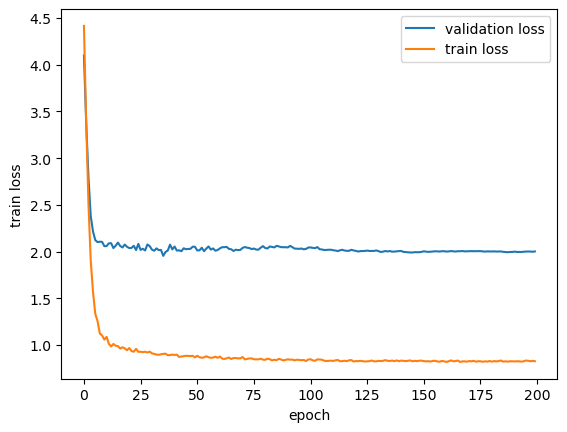

In [121]:
df = pd.concat(episode_data).reset_index()
df = df.rename(columns={"index":"epoch"})
sns.lineplot(df,x='epoch',y='train loss',label = 'validation loss')
sns.lineplot(df,x='epoch',y='valid loss',label = 'train loss')

# Inference

In [92]:
# save model
torch.save(best_model.state_dict(), "resnet152-200e-model")

In [93]:
def predict(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)
        model.train(mode=was_training)
        return class_names[preds[0]]

## Classify Test Data

In [94]:
with open('resnet152-200e-model.csv', 'w', newline='') as csvfile:
    fieldnames = ['ID', 'Label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in tqdm(range(1036)):
        y = predict(best_model, f'test/{i}.jpg')
        writer.writerow({'ID': f'{i}.jpg', 'Label': y})

100%|██████████| 1036/1036 [00:18<00:00, 55.09it/s]
